# # 机器学习练习 5 Scikit-learn的介绍

整理编译：黄海广 haiguang2000@wzu.edu.cn,光城

在本节教程中将会绘制几个图形，于是我们激活matplotlib,使得在notebook中显示内联图。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## 为什么要出这个教程？

`scikit-learn` 提供最先进的机器学习算法。 但是，这些算法不能直接用于原始数据。 原始数据需要事先进行预处理。 因此，除了机器学习算法之外，scikit-learn还提供了一套预处理方法。此外，`scikit-learn` 提供用于流水线化这些估计器的连接器(即转换器，回归器，分类器，聚类器等)。

在本教程中,将介绍`scikit-learn` 函数集，允许流水线估计器、评估这些流水线、使用超参数优化调整这些流水线以及创建复杂的预处理步骤。

## 1.基本用例：训练和测试分类器

对于第一个示例，我们将在数据集上训练和测试一个分类器。 我们将使用此示例来回忆`scikit-learn`的API。

我们将使用`digits`数据集，这是一个手写数字的数据集。

In [2]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

In [3]:
X.shape

(1797, 64)

`X`中的每行包含64个图像像素的强度。 对于`X`中的每个样本，我们得到表示所写数字对应的`y`。

The digit in the image is 0


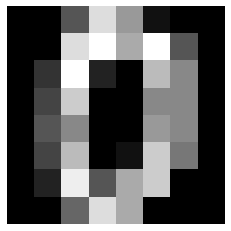

In [4]:
plt.imshow(X[0].reshape(8, 8), cmap='gray');# 下面完成灰度图的绘制
# 灰度显示图像
plt.axis('off')# 关闭坐标轴

print('The digit in the image is {}'.format(y[0]))# 格式化打印

在机器学习中，我们应该通过在不同的数据集上进行训练和测试来评估我们的模型。`train_test_split` 是一个用于将数据拆分为两个独立数据集的效用函数。`stratify`参数可强制将训练和测试数据集的类分布与整个数据集的类分布相同。

In [5]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42)

# 划分数据为训练集与测试集,添加stratify参数，以使得训练和测试数据集的类分布与整个数据集的类分布相同。

一旦我们拥有独立的培训和测试集，我们就可以使用`fit`方法学习机器学习模型。 我们将使用`score`方法来测试此方法，依赖于默认的准确度指标。

In [7]:
from sklearn.linear_model import LogisticRegression  # 求出Logistic回归的精确度得分

clf = LogisticRegression(
    solver='lbfgs', multi_class='ovr', max_iter=5000, random_state=42)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.4f}'.format(clf.__class__.__name__,
                                                  accuracy))

Accuracy score of the LogisticRegression is 0.96


In [8]:
# ?clf.score

`scikit-learn`的API在分类器中是一致的。因此，我们可以通过`RandomForestClassifier`轻松替换`LogisticRegression`分类器。这些更改很小，仅与分类器实例的创建有关。

In [9]:
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier轻松替换LogisticRegression分类器
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the RandomForestClassifier is 0.97


In [10]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the XGBClassifier is 0.96


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__,
                                                  accuracy))

Accuracy score of the GradientBoostingClassifier is 0.96


In [12]:
from sklearn.metrics import balanced_accuracy_score
y_pred = clf.predict(X_test)
accuracy = balanced_accuracy_score(y_pred, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__,
                                                  accuracy))

Accuracy score of the GradientBoostingClassifier is 0.96


In [13]:
from sklearn.svm import SVC, LinearSVC

clf = SVC()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__,
                                                  accuracy))

Accuracy score of the SVC is 0.99


In [14]:
clf = LinearSVC()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__,
                                                  accuracy))

Accuracy score of the LinearSVC is 0.94


C:\Users\hai_g\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


# 标准化您的数据
在学习模型之前可能需要预处理。例如，一个用户可能对创建手工制作的特征或者算法感兴趣，那么他可能会对数据进行一些先验假设。

在我们的例子中，线性模型使用的求解器期望数据被规范化。因此，我们需要在训练模型之前标准化数据。为了观察这个必要条件，我们将检查训练模型所需的迭代次数。

`MinMaxScaler`变换器用于归一化数据，`StandardScaler`用于标准化数据。该标量应该以下列方式应用：学习（即，`fit`方法）训练集上的统计数据并标准化（即，`transform`方法）训练集和测试集。 最后，我们将训练和测试这个模型并得到归一化后的数据集。

In [15]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
clf = LinearSVC()
clf.fit(X_train_scaled, y_train)
accuracy = clf.score(X_test_scaled, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__,
                                                  accuracy))

Accuracy score of the LinearSVC is 0.97


In [17]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = LinearSVC()
clf.fit(X_train_scaled, y_train)
accuracy = clf.score(X_test_scaled, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__,
                                                  accuracy))

Accuracy score of the LinearSVC is 0.95


C:\Users\hai_g\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
y_pred = clf.predict(X_test_scaled)

In [20]:
print(confusion_matrix(y_pred, y_test))

[[45  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  0  0  1  0  2  0]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  1  0 44  0  0  0  0  0  0]
 [ 0  1  0  0 45  0  0  1  0  1]
 [ 0  0  0  1  0 44  0  0  1  1]
 [ 0  1  0  0  0  0 43  0  2  0]
 [ 0  0  0  1  0  0  0 44  0  2]
 [ 0  2  0  0  0  0  1  0 38  1]
 [ 0  0  0  0  0  2  0  0  0 40]]


In [21]:
import pandas as pd

In [22]:
pd.DataFrame(
    (confusion_matrix(y_pred, y_test)),
    columns=range(10),
    index=range(10))

0   1   2   3   4   5   6   7   8   9
0  45   0   0   0   0   0   0   0   0   0
1   0  41   0   0   0   0   1   0   2   0
2   0   0  44   0   0   0   0   0   0   0
3   0   1   0  44   0   0   0   0   0   0
4   0   1   0   0  45   0   0   1   0   1
5   0   0   0   1   0  44   0   0   1   1
6   0   1   0   0   0   0  43   0   2   0
7   0   0   0   1   0   0   0  44   0   2
8   0   2   0   0   0   0   1   0  38   1
9   0   0   0   0   0   2   0   0   0  40

In [23]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.89      0.93      0.91        44
           2       1.00      1.00      1.00        44
           3       0.96      0.98      0.97        45
           4       1.00      0.94      0.97        48
           5       0.96      0.94      0.95        47
           6       0.96      0.93      0.95        46
           7       0.98      0.94      0.96        47
           8       0.88      0.90      0.89        42
           9       0.89      0.95      0.92        42

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



# 交叉验证

分割数据对于评估统计模型性能是必要的。 但是，它减少了可用于学习模型的样本数量。 因此，应尽可能使用交叉验证。有多个拆分也会提供有关模型稳定性的信息。

`scikit-learn`提供了三个函数：`cross_val_score`，`cross_val_predict`和`cross_validate`。 后者提供了有关拟合时间，训练和测试分数的更多信息。 我也可以一次返回多个分数。

In [24]:
from sklearn.model_selection import cross_validate

clf = LogisticRegression(
    solver='lbfgs', multi_class='auto', max_iter=1000, random_state=42)
scores = cross_validate(
    clf, X_train_scaled, y_train, cv=3, return_train_score=True)

In [25]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [26]:
import pandas as pd

df_scores = pd.DataFrame(scores)
df_scores

fit_time  score_time  test_score  train_score
0  0.242349    0.000998    0.975501          1.0
1  0.162569    0.000993    0.957684          1.0
2  0.154585    0.000997    0.962138          1.0

# 网格搜索调参
可以通过穷举搜索来优化超参数。`GridSearchCV`提供此类实用程序，并通过参数网格进行交叉验证的网格搜索。

如下例子，我们希望优化`LogisticRegression`分类器的`C`和`penalty`参数。


In [27]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(
    solver='saga', multi_class='auto', random_state=42, max_iter=5000)
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1],
    'logisticregression__penalty': ['l2', 'l1']
}
tuned_parameters = [{
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', 'l1'],
}]
grid = GridSearchCV(
    clf, tuned_parameters, cv=3, n_jobs=-1, return_train_score=True)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=5000, random_state=42,
                                          solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'penalty': ['l2', 'l1']}],
             return_train_score=True)

我们可以使用`get_params()`检查管道的所有参数。

In [28]:
grid.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 5000,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'saga',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(max_iter=5000, random_state=42, solver='saga'),
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': [{'C': [0.01, 0.1, 1, 10], 'penalty': ['l2', 'l1']}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': True,
 'scoring': None,
 'verbose': 0}

In [29]:
df_grid = pd.DataFrame(grid.cv_results_)
df_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       1.529907      0.129093         0.001660    4.689003e-04    0.01   
1       2.618658      0.459522         0.003658    3.760061e-03    0.01   
2       5.150287      0.541557         0.001330    4.708646e-04     0.1   
3      17.531988      2.149481         0.000997    4.899036e-07     0.1   
4      10.127374      0.915114         0.001995    1.411301e-03       1   
5      44.644031      1.136323         0.001662    9.392566e-04       1   
6      19.567238      1.325637         0.000997    4.052337e-07      10   
7      39.498097      3.290940         0.000665    4.700779e-04      10   

  param_penalty                        params  split0_test_score  \
0            l2  {'C': 0.01, 'penalty': 'l2'}           0.953229   
1            l1  {'C': 0.01, 'penalty': 'l1'}           0.543430   
2            l2   {'C': 0.1, 'penalty': 'l2'}           0.977728   
3            l1   {'C': 0.1, 'penalty': 'l1'}           0.953229   
4            l2     {'C': 1, 'penalty': 'l2'}           0.977728   
5            l1     {'C': 1, 'penalty': 'l1'}           0.977728   
6            l2    {'C': 10, 'penalty': 'l2'}           0.975501   
7            l1    {'C': 10, 'penalty': 'l1'}           0.979955   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.930958           0.935412         0.939866        0.009622   
1           0.563474           0.514477         0.540460        0.020113   
2           0.953229           0.962138         0.964365        0.010125   
3           0.935412           0.942094         0.943578        0.007349   
4           0.957684           0.962138         0.965850        0.008594   
5           0.959911           0.953229         0.963623        0.010340   
6           0.966592           0.955457         0.965850        0.008200   
7           0.966592           0.951002         0.965850        0.011832   

   rank_test_score  split0_train_score  split1_train_score  \
0                7            0.954343            0.953229   
1                8            0.550111            0.536748   
2                4            0.986637            0.989978   
3                6            0.951002            0.961024   
4                1            1.000000            1.000000   
5                5            0.998886            0.998886   
6                1            1.000000            1.000000   
7                1            1.000000            1.000000   

   split2_train_score  mean_train_score  std_train_score  
0            0.952116          0.953229         0.000909  
1            0.532294          0.539718         0.007571  
2            0.987751          0.988122         0.001389  
3            0.957684          0.956570         0.004167  
4            1.000000          1.000000         0.000000  
5            1.000000          0.999258         0.000525  
6            1.000000          1.000000         0.000000  
7            1.000000          1.000000         0.000000

# 流水线操作

`scikit-learn`引入了`Pipeline`对象。它依次连接多个转换器和分类器（或回归器）。我们可以创建一个如下管道：

<AxesSubplot:>

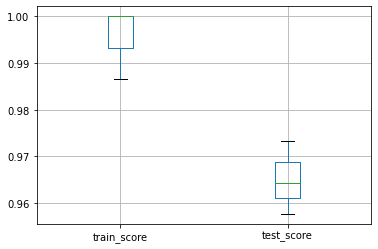

In [30]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
X = X_train
y = y_train
pipe = make_pipeline(
    MinMaxScaler(),
    LogisticRegression(
        solver='saga', multi_class='auto', random_state=42, max_iter=5000))
param_grid = {
    'logisticregression__C': [0.1, 1.0, 10],
    'logisticregression__penalty': ['l2', 'l1']
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1)
scores = pd.DataFrame(
    cross_validate(grid, X, y, cv=3, n_jobs=-1, return_train_score=True))
scores[['train_score', 'test_score']].boxplot()

In [31]:
pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(pipe.__class__.__name__, accuracy))

Accuracy score of the Pipeline is 0.96


我们可以使用`get_params()`检查管道的所有参数。

In [32]:
pipe.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('logisticregression',
   LogisticRegression(max_iter=5000, random_state=42, solver='saga'))],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'logisticregression': LogisticRegression(max_iter=5000, random_state=42, solver='saga'),
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 5000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'saga',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

此外，可以将网格搜索称为任何其他分类器以进行预测。

# 练习 异构数据：当您使用数字以外的数据时

In [44]:
import os
data = pd.read_csv('data/titanic_openml.csv', na_values='?')
data.head()

pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

泰坦尼克号数据集包含分类，文本和数字特征。 我们将使用此数据集来预测乘客是否在泰坦尼克号中幸存下来。

让我们将数据拆分为训练和测试集，并将幸存列用作目标。

In [34]:
y = data['survived']
X = data.drop(columns='survived')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

首先，可以尝试使用`LogisticRegression`分类器，看看它的表现有多好。

In [36]:
clf = LogisticRegression()
clf.fit(X_train, y_train)#这里肯定会报错。

ValueError: could not convert string to float: 'S'

大多数分类器都设计用于处理数值数据。 因此，我们需要将分类数据转换为数字特征。 最简单的方法是使用`OneHotEncoder`对每个分类特征进行读热编码。 让我们以`sex`与`embarked`列为例。 请注意，我们还会遇到一些缺失的数据。 我们将使用`SimpleImputer`用常量值替换缺失值。

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
ohe = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_encoded = ohe.fit_transform(X_train[['sex', 'embarked']])
X_encoded.toarray()

array([[0., 1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.]])

这样，可以对分类特征进行编码。 但是，我们也希望标准化数字特征。 因此，我们需要将原始数据分成2个子组并应用不同的预处理：（i）分类数据的独热编；（ii）数值数据的标准缩放(归一化)。 我们还需要处理两种情况下的缺失值： 对于分类列，我们将字符串'`missing_values`'替换为缺失值，该字符串将自行解释为类别。 对于数值数据，我们将用感兴趣的特征的平均值替换缺失的数据。

In [38]:
col_cat = ['sex', 'embarked']
col_num = ['age', 'sibsp', 'parch', 'fare']

X_train_cat = X_train[col_cat]
X_train_num = X_train[col_num]
X_test_cat = X_test[col_cat]
X_test_num = X_test[col_num]

In [39]:
from sklearn.preprocessing import StandardScaler

scaler_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc = scaler_cat.fit_transform(X_train_cat)
X_test_cat_enc = scaler_cat.transform(X_test_cat)

scaler_num = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_test_num_scaled = scaler_num.transform(X_test_num)

In [40]:
import numpy as np
from scipy import sparse
#转为稀疏矩阵

X_train_scaled = sparse.hstack((X_train_cat_enc,
                                sparse.csr_matrix(X_train_num_scaled)))
X_test_scaled = sparse.hstack((X_test_cat_enc,
                               sparse.csr_matrix(X_test_num_scaled)))

转换完成后，我们现在可以组合所有数值的信息。最后，我们使用`LogisticRegression`分类器作为模型。

In [41]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train_scaled, y_train)
accuracy = clf.score(X_test_scaled, y_test)
print('Accuracy score of the {} is {:.4f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the LogisticRegression is 0.7866
